In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/open-shopee-code-league-marketing-analytics/sample_submission_0_1.csv
/kaggle/input/open-shopee-code-league-marketing-analytics/test.csv
/kaggle/input/open-shopee-code-league-marketing-analytics/train.csv
/kaggle/input/open-shopee-code-league-marketing-analytics/users.csv


In [2]:
user_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/users.csv')
sample_submission_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/sample_submission_0_1.csv')
train_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/train.csv')
test_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/test.csv')

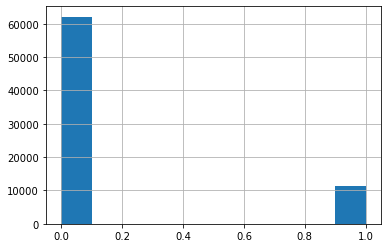

In [40]:
train_df.open_flag.hist()

In [4]:
test_df.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,10,34,134,0,6,18,0
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,5,5,5,0,0,0,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,13,19,38,2,2,2,2
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,43,110,173,2,5,5,3
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,4,12,39,0,0,2,4


In [5]:
train_df_index = ['row_id']
train_df_cat = ['country_code']
train_df_num = ['subject_line_length',
                'last_open_day', 'last_login_day', 'last_checkout_day',
                'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 
                'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days',
                'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days']
train_df_dat = ['grass_date']
train_df_none = ['user_id']
train_df_y = ['open_flag']

In [6]:
# Additional libraries
import networkx
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 1. Preprocessing
## 1.1. Users information

In [7]:
user_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/users.csv')

### attr_1

In [8]:
# Drop column "attr_1" as it is "useless"
user_df = user_df.drop("attr_1",axis = 1)

### attr_2

In [9]:
user_df = user_df.drop("attr_2",axis = 1)

### attr_3

In [10]:
# Get one hot encoding of columns "attr_3"
one_hot = pd.get_dummies(user_df["attr_3"],prefix="attr_3",prefix_sep='_',dtype=float)

# Drop column "attr_3" as it is now encoded
user_df = user_df.drop("attr_3",axis = 1)

# Join the encoded df
user_df = user_df.join(one_hot)

### domain

In [11]:
# Get one hot encoding of columns "domain"
one_hot = pd.get_dummies(user_df["domain"],prefix="domain",prefix_sep='')

# Drop column "domain" as it is now encoded
user_df = user_df.drop("domain",axis = 1)

# Join the encoded df
user_df = user_df.join(one_hot)

### age

In [12]:
# Fill in age < 18 and age > 80 with random uniform distribution from 18 to 80
age_below_18 = user_df['age']<18
age_above_80 = user_df['age']>80
age_nan = user_df['age'].isna()
user_df.loc[age_below_18, 'age'] = np.random.uniform(18, 80, size=age_below_18.sum())
user_df.loc[age_above_80, 'age'] = np.random.uniform(18, 80, size=age_above_80.sum())
user_df.loc[age_nan, 'age'] = np.random.uniform(18, 80, size=age_nan.sum())

### Check preprocessed user information

In [13]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127886 entries, 0 to 127885
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                127886 non-null  int64  
 1   age                    127886 non-null  float64
 2   attr_3_0.0             127886 non-null  float64
 3   attr_3_1.0             127886 non-null  float64
 4   attr_3_2.0             127886 non-null  float64
 5   attr_3_3.0             127886 non-null  float64
 6   attr_3_4.0             127886 non-null  float64
 7   domain@163.com         127886 non-null  uint8  
 8   domain@gmail.com       127886 non-null  uint8  
 9   domain@hotmail.com     127886 non-null  uint8  
 10  domain@icloud.com      127886 non-null  uint8  
 11  domain@live.com        127886 non-null  uint8  
 12  domain@outlook.com     127886 non-null  uint8  
 13  domain@qq.com          127886 non-null  uint8  
 14  domain@rocketmail.com  127886 non-nu

## 1.2. Training data

In [14]:
train_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/train.csv')

### Process 'never open'

In [15]:
train_df['last_open_day'] = train_df['last_open_day'].replace(['Never open'],'1000')
train_df['last_login_day'] = train_df['last_login_day'].replace(['Never login'],'20000')
train_df['last_checkout_day'] = train_df['last_checkout_day'].replace(['Never checkout'],'1000')

In [16]:
train_df['last_open_day'] = train_df['last_open_day'].astype('int64')
train_df['last_login_day'] = train_df['last_login_day'].astype('int64')
train_df['last_checkout_day'] = train_df['last_checkout_day'].astype('int64')

### Process categorical data

In [17]:
def one_hot_country(df):
    one_hot = pd.get_dummies(df["country_code"],prefix="country",prefix_sep='_',dtype=int)
#     _df = df.copy()
#     _df = _df.join(one_hot)
#     _df = _df.drop("country_code",axis = 1)
#     return _df
    return one_hot

def convert_datetime_grassdate(df):
    _df = df.copy()
    _df['grass_date'] = pd.to_datetime(_df['grass_date'])
    _df['email_sent_dayofweek'] = _df['grass_date'].dt.dayofweek
    _df = _df.drop("grass_date",axis = 1)
    return _df

def one_hot_weekday(df):
    one_hot = pd.get_dummies(df["email_sent_dayofweek"],prefix="email_sent_weekday",prefix_sep='_',dtype=int)
#     _df = df.copy()
#     _df = _df.join(one_hot)
#     _df = _df.drop("email_sent_dayofweek",axis = 1)
#     return _df
    return one_hot

In [18]:
train_df = convert_datetime_grassdate(train_df)
# one-hot encoding
train_df_country = one_hot_country(train_df)
train_df_weekday = one_hot_weekday(train_df)

### Process numerical data

In [19]:
def process_numerical_data(df, numerical_cols, drop_numerical_columns):
#     sacalar = MinMaxScaler()
    sacalar = StandardScaler() #if using StandardScaler
    scale_numerical_cols = list(set(numerical_cols)-set(drop_numerical_columns))
    df_numerical = sacalar.fit_transform(df[scale_numerical_cols])
    df_numerical = pd.DataFrame(df_numerical,columns=scale_numerical_cols)
    return df_numerical

drop_numerical_columns = []
train_df_numerical = process_numerical_data(train_df,train_df_num,drop_numerical_columns)
train_df_numerical

,open_count_last_30_days,login_count_last_30_days,open_count_last_10_days,checkout_count_last_10_days,login_count_last_60_days,checkout_count_last_30_days,open_count_last_60_days,checkout_count_last_60_days,last_open_day,last_login_day,subject_line_length,login_count_last_10_days,last_checkout_day
0,-0.170770,0.468020,-0.519845,-0.315128,0.696051,0.286749,-0.128997,0.327540,-0.378412,-0.096573,0.030628,0.269489,-0.661601
1,1.360888,0.600111,0.620380,0.031205,0.570736,-0.233676,1.516103,-0.101642,-0.412008,-0.098143,0.030628,0.716438,-0.686233
2,0.266846,1.154889,-0.519845,1.416536,0.974529,2.108240,0.883372,1.543556,-0.395210,-0.097358,0.476291,1.163387,-0.693622
3,-0.608387,-0.060340,-0.519845,0.031205,0.278333,0.026536,-0.508635,0.041419,-0.277624,-0.094218,0.476291,0.046014,-0.575389
4,-0.608387,-0.535865,-0.519845,-0.315128,-0.612798,-0.363783,-0.635181,-0.387763,0.320383,-0.096573,0.476291,-0.475426,-0.161572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73534,-0.389579,-0.667955,-0.519845,-0.315128,-0.682417,-0.363783,-0.508635,-0.387763,-0.361614,-0.073021,-0.415034,-0.624409,-0.018706
73535,-0.608387,-0.667955,-0.519845,-0.315128,-0.682417,-0.363783,-0.508635,-0.387763,-0.287703,-0.093433,-0.504167,-0.624409,-0.580315
73536,-0.608387,-0.667955,-0.519845,-0.315128,-0.682417,-0.363783,-0.635181,-0.387763,2.917347,15.600197,-1.038962,-0.624409,1.757260
73537,0.266846,-0.667955,0.620380,-0.315128,-0.682417,-0.363783,-0.128997,-0.387763,-0.425446,-0.074591,-0.504167,-0.624409,1.757260


### Concatenate all columns

In [20]:
train_df_new = pd.concat([train_df[['row_id', 'user_id']], train_df_numerical, train_df_country, train_df_weekday],axis=1)

## 1.3. Merging training data and users information

In [21]:
train_df_new.set_index('row_id')
train_df_new = train_df_new.merge(user_df,on='user_id')
train_df_new = train_df_new.drop(["user_id","row_id"],axis = 1)
train_df_new = pd.concat([train_df_new, train_df['open_flag']],axis=1)
train_df_new = train_df_new.dropna(axis=0)

In [44]:
# Class count
count_class_0, count_class_1 = train_df_new.open_flag.value_counts()

# Divide by class
df_class_0 = train_df_new[train_df_new['open_flag'] == 0]
df_class_1 = train_df_new[train_df_new['open_flag'] == 1]

In [45]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

Random over-sampling:
1    62083
0    62083
Name: open_flag, dtype: int64


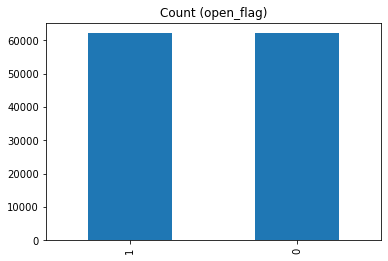

In [47]:
print('Random over-sampling:')
print(df_test_over.open_flag.value_counts())

df_test_over.open_flag.value_counts().plot(kind='bar', title='Count (open_flag)');

In [48]:
train_df_features = df_test_over.iloc[:, :-1]
train_df_labels = df_test_over.iloc[:, -1]

In [49]:
train_df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124166 entries, 0 to 36756
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   open_count_last_30_days      124166 non-null  float64
 1   login_count_last_30_days     124166 non-null  float64
 2   open_count_last_10_days      124166 non-null  float64
 3   checkout_count_last_10_days  124166 non-null  float64
 4   login_count_last_60_days     124166 non-null  float64
 5   checkout_count_last_30_days  124166 non-null  float64
 6   open_count_last_60_days      124166 non-null  float64
 7   checkout_count_last_60_days  124166 non-null  float64
 8   last_open_day                124166 non-null  float64
 9   last_login_day               124166 non-null  float64
 10  subject_line_length          124166 non-null  float64
 11  login_count_last_10_days     124166 non-null  float64
 12  last_checkout_day            124166 non-null  float64
 13  

# 2. Process test data

In [24]:
test_df = pd.read_csv('/kaggle/input/open-shopee-code-league-marketing-analytics/test.csv')

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55970 entries, 0 to 55969
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country_code                 55970 non-null  int64 
 1   grass_date                   55970 non-null  object
 2   user_id                      55970 non-null  int64 
 3   subject_line_length          55970 non-null  int64 
 4   last_open_day                55970 non-null  object
 5   last_login_day               55970 non-null  object
 6   last_checkout_day            55970 non-null  object
 7   open_count_last_10_days      55970 non-null  int64 
 8   open_count_last_30_days      55970 non-null  int64 
 9   open_count_last_60_days      55970 non-null  int64 
 10  login_count_last_10_days     55970 non-null  int64 
 11  login_count_last_30_days     55970 non-null  int64 
 12  login_count_last_60_days     55970 non-null  int64 
 13  checkout_count_last_10_days  55

In [26]:
test_df_index = ['row_id']
test_df_cat = ['country_code']
test_df_num = ['subject_line_length',
                'last_open_day', 'last_login_day', 'last_checkout_day',
                'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 
                'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days',
                'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days']
test_df_dat = ['grass_date']
test_df_none = ['user_id']
test_df_y = ['open_flag']

In [27]:
test_df['last_open_day'] = test_df['last_open_day'].replace(['Never open'],'1000')
test_df['last_login_day'] = test_df['last_login_day'].replace(['Never login'],'20000')
test_df['last_checkout_day'] = test_df['last_checkout_day'].replace(['Never checkout'],'1000')

In [28]:
test_df['last_open_day'] = test_df['last_open_day'].astype('int64')
test_df['last_login_day'] = test_df['last_login_day'].astype('int64')
test_df['last_checkout_day'] = test_df['last_checkout_day'].astype('int64')

In [29]:
def process_numerical_data(df, numerical_cols, drop_numerical_columns):
#     sacalar = MinMaxScaler()
    sacalar = StandardScaler() #if using StandardScaler
    scale_numerical_cols = list(set(numerical_cols)-set(drop_numerical_columns))
    df_numerical = sacalar.fit_transform(df[scale_numerical_cols])
    df_numerical = pd.DataFrame(df_numerical,columns=scale_numerical_cols)
    return df_numerical

drop_numerical_columns = []
test_df_numerical = process_numerical_data(test_df,test_df_num,drop_numerical_columns)
test_df_numerical

,open_count_last_30_days,login_count_last_30_days,open_count_last_10_days,checkout_count_last_10_days,login_count_last_60_days,checkout_count_last_30_days,open_count_last_60_days,checkout_count_last_60_days,last_open_day,last_login_day,subject_line_length,login_count_last_10_days,last_checkout_day
0,0.116595,0.199898,0.699230,-0.321274,1.136414,0.339208,-0.146192,0.847721,-0.408712,-0.093870,-0.587544,0.073062,-0.628414
1,-0.301217,-0.551936,0.128769,-0.321274,-0.623752,-0.392734,-0.477559,-0.416894,-0.468463,-0.091213,-0.587544,-0.284701,0.316751
2,-0.510124,-0.188982,-0.441692,0.250045,-0.173477,-0.148753,-0.588015,-0.276381,-0.387799,-0.094756,-1.402140,0.287721,-0.653959
3,-0.510124,2.170224,-0.441692,0.250045,1.668557,0.217218,-0.588015,-0.065612,-0.301161,-0.091213,-0.506084,2.434301,-0.648850
4,-0.510124,-0.370459,-0.441692,-0.321274,-0.159832,-0.392734,-0.588015,-0.276381,-0.471450,-0.091213,-1.565059,-0.356254,-0.523680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,-0.510124,-0.681563,-0.441692,-0.321274,-0.691976,-0.392734,-0.588015,-0.416894,2.498160,-0.092099,0.878729,-0.642464,-0.641186
55966,-0.510124,-0.681563,-0.441692,-0.321274,-0.691976,-0.392734,-0.477559,-0.416894,-0.313111,0.614791,0.878729,-0.642464,2.421659
55967,-0.510124,-0.681563,-0.441692,-0.321274,-0.691976,-0.392734,-0.588015,-0.416894,2.498160,-0.089441,0.064133,-0.642464,1.892877
55968,0.534407,-0.681563,0.699230,-0.321274,-0.691976,-0.392734,0.958367,-0.416894,-0.474438,-0.091213,0.064133,-0.642464,-0.646295


In [30]:
test_df = convert_datetime_grassdate(test_df)
# one-hot encoding
test_df_country = one_hot_country(test_df)
test_df_weekday = one_hot_weekday(test_df)

In [31]:
test_df_features = pd.concat([test_df[['row_id', 'user_id']], test_df_numerical, test_df_country, test_df_weekday],axis=1)
test_df_features.set_index('row_id')
test_df_features = test_df_features.merge(user_df,on='user_id')
test_df_features = test_df_features.drop(["user_id", "row_id"],axis = 1)

In [32]:
test_df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55970 entries, 0 to 55969
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   open_count_last_30_days      55970 non-null  float64
 1   login_count_last_30_days     55970 non-null  float64
 2   open_count_last_10_days      55970 non-null  float64
 3   checkout_count_last_10_days  55970 non-null  float64
 4   login_count_last_60_days     55970 non-null  float64
 5   checkout_count_last_30_days  55970 non-null  float64
 6   open_count_last_60_days      55970 non-null  float64
 7   checkout_count_last_60_days  55970 non-null  float64
 8   last_open_day                55970 non-null  float64
 9   last_login_day               55970 non-null  float64
 10  subject_line_length          55970 non-null  float64
 11  login_count_last_10_days     55970 non-null  float64
 12  last_checkout_day            55970 non-null  float64
 13  country_1       

# 3. Modelling

In [50]:
# split the data into train and test
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_df_features,train_df_labels,test_size=0.2,random_state=27)

### Random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

# train_x, test_x, train_y, test_y 
rf_clf = RandomForestClassifier(max_features='auto', max_depth=None, random_state=10)
rf_clf.fit(train_x, train_y)

RandomForestClassifier(random_state=10)

In [52]:
y_true, y_pred = test_y , rf_clf.predict(test_x)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12398
           1       0.99      0.99      0.99     12436

    accuracy                           0.99     24834
   macro avg       0.99      0.99      0.99     24834
weighted avg       0.99      0.99      0.99     24834



In [53]:
test_y_pred = rf_clf.predict(test_df_features)

In [54]:
df_result = pd.DataFrame.from_dict(dict({'row_id':list(test_df['row_id']),
                                         'open_flag':test_y_pred}))
df_result

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [55]:
df_result.to_csv('submission_ff.csv', index=False)

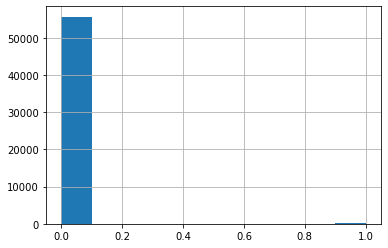

In [56]:
df_result.open_flag.hist()

### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

bg_clf = BaggingClassifier(base_estimator=SVC(), n_estimators=20, random_state=10, max_features=35)
bg_clf.fit(train_x, train_y)

In [ ]:
y_true, y_pred = test_y , bg_clf.predict(test_x)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

In [ ]:
test_y_pred = bg_clf.predict(test_df_features)
df_result = pd.DataFrame.from_dict(dict({'row_id':list(df_test['row_id']),
                                         'open_flag':test_y_pred}))
df_result

## MLP

In [154]:
from sklearn.neural_network import MLPClassifier
input_size = train_df_features.shape[1]
NN = MLPClassifier(
    hidden_layer_sizes=(100, 100,),
    solver='adam',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000, 
    shuffle=True, 
    random_state=27,
    early_stopping=True)
NN.fit(train_x,train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100), max_iter=1000,
              random_state=27)

In [155]:
NN_predicted_y = NN.predict(test_x)

In [156]:
y_true, y_pred = test_y , NN_predicted_y
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     12449
           1       0.00      0.00      0.00      2259

    accuracy                           0.85     14708
   macro avg       0.42      0.50      0.46     14708
weighted avg       0.72      0.85      0.78     14708



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4. Make prediction on test set

In [157]:
predicted_test = NN.predict(test_df_features)
predicted_test

array([0, 0, 0, ..., 0, 0, 0])

In [158]:
submission = test_df[['row_id']]
submission['open_flag'] = predicted_test
submission.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [159]:
submission[submission.open_flag==1].count()

row_id       0
open_flag    0
dtype: int64